# Active Inference cadCAD model

This notebook explores active inference agent modeling 
This notebook adds a frontend interface for visualizing the model outputs and playing around with the parameters.
![](opsci_baseline_stock&flow.png)

## Developing Active Inference Agents in cadCAD

An active inference agent consists of the following matrices:
- $A$ -> $P(o|s)$ the generative model's prior beliefs about how hidden states relate to observations
- $B$ -> $𝑃(𝑠_𝑡∣𝑠_{𝑡−1},𝑢_{𝑡−1})$ the generative model's prior beliefs about controllable transitions between hidden states over time
- $C$ -> $P(o)$ the biased generative model's prior preference for particular observations encoded in terms of probabilities
- $D$ -> $P(s)$ the generative model's prior belief over hidden states at the first timestep 

## cadCAD Standard Notebook Layout

### 0. Dependencies

In [1]:
import pandas as pd
import numpy as np
from random import normalvariate, random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor
from cadCAD import configs

from pymdp import utils
from pymdp.maths import softmax

# Additional dependencies

# For analytics
import itertools

# For visualization
import plotly.express as px

# local utils
import utils as u

### 0. Useful functions

In [2]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

def create_B_matrix():
  B = np.zeros( (len(grid_locations), len(grid_locations), len(actions)) )

  for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[next_state, curr_state, action_id] = 1.0
  return B

Dimensionality of hidden states: 9
Dimensionality of observations: 9


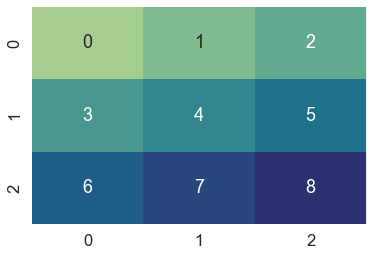

In [3]:
grid_locations = list(itertools.product(range(3), repeat = 2))
n_states = len(grid_locations)
n_observations = len(grid_locations)

print(f'Dimensionality of hidden states: {n_states}')
print(f'Dimensionality of observations: {n_observations}')
u.plot_grid(grid_locations)

In [4]:
grid_locations[0]

(0, 0)

In [5]:
""" Fill out the components of the generative model """

A = np.eye(n_observations, n_states)

B = create_B_matrix()

C = utils.onehot(grid_locations.index( (2, 2) ), n_observations) # make the agent prefer location (2,2) (lower right corner of grid world)

D = utils.onehot(grid_locations.index( (1,2) ), n_states) # start the agent with the prior belief that it starts in location (1,2) 

actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

The pymdp inference loop has the following steps:
- initialize prior to the D matrix
- get observation index from `grid_locations`
- (q_s) perform inference over hidden states with `infer_states`, passing in the observation index, the A matrix, and the prior
- calculate expected free energy, passing in the A, B, C matrices, the inferences (q_s) from the previous step, and available actions
- compute action posterior (it's the softmax of -G)
- sample the action posterior the get the action
- compute the prior for next state with the dot product of the B matrix (indexed with the chosen action) and the current inference (q_s)

In cadCAD terms:
- policy functions:
    - `get_observation`
    - `infer_states`
    - `calc_efe`
    - `calc_action_posterior`
    - `sample_action`
    - `calc_next_prior`
    - `update_env_state`
- states:
    - `prior_A`
    - `prior_B`
    - `prior_C`
    - `env_state`

### 1. State Variables

In [6]:
initial_state = {
    'prior_A': A,
    'prior_B': B,
    'prior_C': C,
    'prior': D,
    'env': grid_locations[0]
}

### 2. System Parameters

In [7]:
system_params = {
    'prior_A': A,
    'prior_B': B,
    'prior_C': C,
    'prior': D,
    'env': grid_locations,
    'actions': ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
}

### 3. Policy Functions

- `get_observation`
- `infer_states`
- `calc_efe`
- `calc_action_posterior`
- `sample_action`
- `calc_next_prior`
- `update_env_state`

In [8]:
def p_actinf(params, substep, state_history, previous_state):
    # get obs_idx
    obs_idx = grid_locations.index(previous_state['env_state'])

    # infer_states
    qs_current = u.infer_states(obs_idx, previous_state['prior_A'], previous_state['prior'])

    # calc efe
    G = u.calculate_G(previous_state['prior_A'], previous_state['prior_B'], previous_state['prior_C'], qs_current, params['actions'])

    # calc action posterior
    Q_u = softmax(-G)

    # sample action
    chosen_action = utils.sample(Q_u)

    # calc next prior
    prior = previous_state['prior_B'][:,:,chosen_action].dot(qs_current) 

    # update env state
    action_label = params['actions'][chosen_action]

    (Y, X) = previous_state['env_state']

    if action_label == "UP": 
          
        Y_new = Y - 1 if Y > 0 else Y
        X_new = X

    elif action_label == "DOWN": 

        Y_new = Y + 1 if Y < 2 else Y
        X_new = X

    elif action_label == "LEFT": 
        Y_new = Y
        X_new = X - 1 if X > 0 else X

    elif action_label == "RIGHT": 
        Y_new = Y
        X_new = X +1 if X < 2 else X

    elif action_label == "STAY":
        Y_new, X_new = Y, X 
        
    current_state = (Y_new, X_new) # store the new grid location

    return {'update_prior': prior,
            'update_env': current_state}

### 4. State Update Functions

In [9]:
def s_prior(params, substep, state_history, previous_state, policy_input):
    updated_prior = policy_input['update_prior']
    return 'prior', updated_prior

def s_env(params, substep, state_history, previous_state, policy_input):
    updated_env_state = policy_input['update_env']
    return 'env_state', updated_env_state

### 5. Partial State Update Blocks

In [10]:
partial_state_update_blocks = [
    {
        'policies': {
            'p_actinf': p_actinf
        },
        'variables': {
            'prior': s_prior,
            'env': s_env
        }
    }
]

### 6. Configuration

In [11]:
def generate_sim_config(monte_carlo_runs=1,
                   timesteps=1,
                   system_params=system_params):
    sim_config = config_sim({
        'N': monte_carlo_runs, # the number of times we'll run the simulation ("Monte Carlo runs")
        'T': range(timesteps), # the number of timesteps the simulation will run for
        'M': system_params # the parameters of the system
    })

    return sim_config

In [12]:
def configure_experiment(initial_state,
                      partial_state_update_blocks,
                      sim_config):
    experiment = Experiment()
    experiment.append_configs(
        initial_state=initial_state,
        partial_state_update_blocks=partial_state_update_blocks,
        sim_configs=sim_config
    )

    return experiment

In [13]:
del configs[:] # Clear any prior configs

sim_config = generate_sim_config()
experiment = configure_experiment(initial_state, partial_state_update_blocks, sim_config)

In [14]:
print(system_params)

{'prior_A': array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]]), 'prior_B': array([[[1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0

### 7. Execution

In [15]:
def execute_simulation(experiment, configs):
    exec_context = ExecutionContext()
    configs = experiment.configs
    simulation = Executor(exec_context=exec_context, configs=configs)
    raw_result, tensor_field, sessions = simulation.execute()

    return raw_result

In [16]:
exec_context = ExecutionContext()
configs = experiment.configs
simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1, 1, 13, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1, 1, 13, 5)
Execution Method: local_simulations
Execution Mode: parallelized


### 8. Analysis

In [13]:
pd.options.plotting.backend = "plotly"

In [15]:
df = pd.DataFrame(raw_result)
df

,funding_pool,researcher_value,journal_value,losses,simulation,subset,run,substep,timestep
0,1000,100.0,0.0,0.0,0,0,1,0,0
1,1000,100.0,10.0,0.0,0,0,1,1,1
2,1000,100.0,20.0,0.0,0,0,1,1,2
3,1000,100.0,30.0,0.0,0,0,1,1,3
4,1000,100.0,40.0,0.0,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...
94,400,104.0,170.0,540.0,0,8,9,1,6
95,300,103.0,200.0,630.0,0,8,9,1,7
96,200,102.0,230.0,720.0,0,8,9,1,8
97,100,101.0,260.0,810.0,0,8,9,1,9
